In [15]:
import itertools
import math
import numpy as np
import pandas as pd

try:
    from scipy.stats import norm
    _has_scipy = True
except Exception:
    _has_scipy = False

import matplotlib.pyplot as plt
from itertools import product



Load dataframe and join data 

In [16]:
base_path = "../Data/eth_final_df.csv"
lstm_path = "../Results/eth_lstm_prediction.csv"
egarch_path = "../Results/eth_egarch_prediction.csv"
xgb_path = "../Results/eth_xgb_prediction.csv"
vanilla_t_path  = "../Results/eth_transformer_prediction.csv"
dense_t_path = "../Results/btc_transformer_dense_prediction.csv"
random_t_path = "../Results/btc_transformer_random_prediction.csv"


H = 1  # forecast horizon for DM (h-step ahead)
ASSUME_INPUTS_ARE_VOL = True  # True if columns are volatility (sigma), False if already variance 
SAVE_DM_CSV = "../Results/eth_dm_results.csv"  

def load_actual(base_path):
    df = pd.read_csv(base_path, parse_dates=["timestamp"])
    need = ["timestamp", "vol_future"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError("Missing columns in base file: " + ", ".join(missing))
    df = df[need].copy()
    if df["timestamp"].dt.tz is None:
        df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
    df = df.drop_duplicates(subset="timestamp").sort_values("timestamp")
    return df.rename(columns={"vol_future": "actual_vol"})

def load_pred(path, new_col_name):
    d = pd.read_csv(path, parse_dates=["timestamp"])
    if d["timestamp"].dt.tz is None:
        d["timestamp"] = d["timestamp"].dt.tz_localize("UTC")
    pred_col = None
    for c in d.columns:
        if c.lower() in {"pred_vol_future", "predicted_volatility", "predicted"}:
            pred_col = c
            break
    if pred_col is None:
        raise ValueError("Could not find prediction column in " + path)
    d = d[["timestamp", pred_col]].rename(columns={pred_col: new_col_name})
    return d.drop_duplicates(subset="timestamp").sort_values("timestamp")

actual = load_actual(base_path)

pred_dfs = []
for path, name in [
    (egarch_path, "pred_egarch"),
    (xgb_path, "pred_xgb"),
    (lstm_path, "pred_lstm"),
    (vanilla_t_path, "pred_vanilla_t"),
    (dense_t_path, "pred_dense_t"),
    (random_t_path, "pred_random_t")
]:
    pred_dfs.append(load_pred(path, name))
    

df = actual.copy()
for p in pred_dfs:
    df = df.merge(p, on="timestamp", how="inner")

df = df.sort_values("timestamp").drop_duplicates(subset=["timestamp"]).reset_index(drop=True)

print("=== Joined Data Preview (first 10 rows) ===")
display(df.head(10))
print("[info] shape:", df.shape)
print("[info] columns:", list(df.columns))

=== Joined Data Preview (first 10 rows) ===


,timestamp,actual_vol,pred_egarch,pred_xgb,pred_lstm,pred_vanilla_t,pred_dense_t,pred_random_t
0,2025-08-22 17:00:00+00:00,-4.832117,0.018098,-4.786462,-4.386461,0.006539,0.006052,1.0
1,2025-08-22 18:00:00+00:00,-4.931836,0.016870,-4.819179,-4.590931,0.006947,0.004495,1.0
2,2025-08-22 19:00:00+00:00,-4.982131,0.015033,-4.948697,-4.741147,0.006524,0.005559,1.0
3,2025-08-22 20:00:00+00:00,-4.768548,0.014399,-4.980243,-4.786739,0.006191,0.003988,1.0
4,2025-08-22 21:00:00+00:00,-5.018062,0.012701,-4.974939,-4.770797,0.006293,0.003309,1.0
5,2025-08-22 22:00:00+00:00,-5.509660,0.011529,-4.942721,-4.940384,0.006546,0.003076,1.0
6,2025-08-22 23:00:00+00:00,-5.440454,0.011723,-5.087213,-5.129026,0.006546,0.002940,1.0
7,2025-08-23 00:00:00+00:00,-5.034038,0.010932,-5.198784,-5.187375,0.006534,0.002447,1.0
8,2025-08-23 01:00:00+00:00,-4.386261,0.010325,-5.180520,-5.294550,0.006534,0.002963,1.0
9,2025-08-23 02:00:00+00:00,-4.868113,0.010337,-5.068055,-5.102383,0.005717,0.002848,1.0


[info] shape: (1231, 8)
[info] columns: ['timestamp', 'actual_vol', 'pred_egarch', 'pred_xgb', 'pred_lstm', 'pred_vanilla_t', 'pred_dense_t', 'pred_random_t']


Define Squared Error and QLIKE 

In [17]:
def squared_error(y, yhat):
    return (y - yhat) ** 2

def qlike(y, yhat, inputs_are_volatility=True, eps=1e-12):
    if inputs_are_volatility:
        y_var = (y ** 2).astype(float)
        yhat_var = (yhat ** 2).astype(float)
    else:
        y_var = y.astype(float)
        yhat_var = yhat.astype(float)
    yhat_var = np.clip(yhat_var, eps, None)
    return np.log(yhat_var) + (y_var / yhat_var)

model_cols = [c for c in df.columns if c.startswith("pred_")]
for mc in model_cols:
    se_col = mc.replace("pred_", "") + "_se"
    ql_col = mc.replace("pred_", "") + "_qlike"
    df[se_col] = squared_error(df["actual_vol"], df[mc])
    df[ql_col] = qlike(df["actual_vol"], df[mc], inputs_are_volatility=ASSUME_INPUTS_ARE_VOL)

print("=== Loss Columns Preview (first 10 rows) ===")
loss_cols = ["timestamp", "actual_vol"] + model_cols + \
            [mc.replace("pred_", "") + "_se" for mc in model_cols] + \
            [mc.replace("pred_", "") + "_qlike" for mc in model_cols]
display(df[loss_cols].head(10))


=== Loss Columns Preview (first 10 rows) ===


,timestamp,actual_vol,pred_egarch,pred_xgb,pred_lstm,pred_vanilla_t,pred_dense_t,pred_random_t,egarch_se,xgb_se,lstm_se,vanilla_t_se,dense_t_se,random_t_se,egarch_qlike,xgb_qlike,lstm_qlike,vanilla_t_qlike,dense_t_qlike,random_t_qlike
0,2025-08-22 17:00:00+00:00,-4.832117,0.018098,-4.786462,-4.386461,0.006539,0.006052,1.0,23.524581,0.002084,0.198609,23.412590,23.407877,34.013583,71279.191009,4.150751,4.170564,546023.704266,6.374365e+05,23.349349
1,2025-08-22 18:00:00+00:00,-4.931836,0.016870,-4.819179,-4.590931,0.006947,0.004495,1.0,24.489690,0.012692,0.116216,24.391577,24.367363,35.186677,85456.431931,4.192507,4.202192,503963.477699,1.203766e+06,24.323004
2,2025-08-22 19:00:00+00:00,-4.982131,0.015033,-4.948697,-4.741147,0.006524,0.005559,1.0,24.971652,0.001118,0.058074,24.886681,24.877056,35.785893,109821.556387,4.211807,4.216798,583149.612052,8.031107e+05,24.821629
3,2025-08-22 20:00:00+00:00,-4.768548,0.014399,-4.980243,-4.786739,0.006191,0.003988,1.0,22.876584,0.044815,0.000331,22.798129,22.777101,33.276143,109659.786642,4.127750,4.124113,593280.093735,1.429454e+06,22.739047
4,2025-08-22 21:00:00+00:00,-5.018062,0.012701,-4.974939,-4.770797,0.006293,0.003309,1.0,25.308579,0.001860,0.061140,25.244148,25.214170,36.217075,156091.042976,4.226238,4.231371,635828.204151,2.299793e+06,25.180949
5,2025-08-22 22:00:00+00:00,-5.509660,0.011529,-4.942721,-4.940384,0.006546,0.003076,1.0,30.483531,0.321420,0.324076,30.428528,30.390263,42.375679,228381.814498,4.438392,4.438622,708518.377377,3.208240e+06,30.356357
6,2025-08-22 23:00:00+00:00,-5.440454,0.011723,-5.087213,-5.129026,0.006546,0.002940,1.0,29.726236,0.124779,0.096987,29.669801,29.630537,41.479444,215348.606803,4.397156,4.394956,690830.547199,3.423956e+06,29.598535
7,2025-08-23 00:00:00+00:00,-5.034038,0.010932,-5.198784,-5.187375,0.006534,0.002447,1.0,25.451717,0.027141,0.023512,25.407367,25.366178,36.409613,212055.235899,4.234475,4.234210,593529.731534,4.232736e+06,25.341536
8,2025-08-23 01:00:00+00:00,-4.386261,0.010325,-5.180520,-5.294550,0.006534,0.002963,1.0,19.329970,0.630847,0.824989,19.296652,19.265290,29.011810,180465.777673,4.006684,4.019683,450605.174990,2.191312e+06,19.239287
9,2025-08-23 02:00:00+00:00,-4.868113,0.010337,-5.068055,-5.102383,0.005717,0.002848,1.0,23.799274,0.039977,0.054882,23.754220,23.726257,34.434746,221763.917918,4.168568,4.169696,724941.175139,2.921863e+06,23.698520


Create DM helpers 

In [18]:
# Compute a robust variance of that difference series (accounting for autocorrelation)
def _nw_longrun_var(d, h):
    d = np.asarray(d, dtype=float)
    T = d.size
    d = d - d.mean()
    def acov(k):
        return np.dot(d[:T - k], d[k:]) / T
    gamma0 = acov(0)
    q = max(h - 1, 0)
    lrv = gamma0
    for k in range(1, q + 1):
        w = 1.0 - k / (q + 1.0)
        lrv += 2.0 * w * acov(k)
    return lrv

#Takes two loss series (e.g. squared error or QLIKE) from two models and computes DM statistic and p-value

def dm_test_from_losses(loss_a, loss_b, h=1):
    d = (loss_a - loss_b).dropna().to_numpy()
    T = d.size
    if T < 5:
        raise ValueError("Not enough overlapping observations for DM test.")
    dbar = d.mean()
    lrv = _nw_longrun_var(d, h)
    if lrv <= 0:
        lrv = np.var(d, ddof=1)
    dm = dbar / math.sqrt(lrv / T)
    hln = math.sqrt((T + 1 - 2 * h + (h * (h - 1)) / T) / T)
    dm_hln = dm * hln
    if _has_scipy:
        pval = 2.0 * (1.0 - norm.cdf(abs(dm_hln)))
    else:
        def norm_cdf(x):
            return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))
        pval = 2.0 * (1.0 - norm_cdf(abs(dm_hln)))
    return dm_hln, pval, dbar


Run pairwise DM tests

In [19]:
# build maps
name_map = {mc: mc.replace("pred_", "") for mc in model_cols}
se_map = {name_map[mc]: name_map[mc] + "_se" for mc in model_cols}
ql_map = {name_map[mc]: name_map[mc] + "_qlike" for mc in model_cols}

# pairwise comparisons
results = []
pairs = list(itertools.combinations(name_map.values(), 2))
for a, b in pairs:
    stat_se, p_se, mean_diff_se = dm_test_from_losses(df[se_map[a]], df[se_map[b]], h=H)
    stat_ql, p_ql, mean_diff_ql = dm_test_from_losses(df[ql_map[a]], df[ql_map[b]], h=H)
    results.append({
        "loss": "SE",
        "model_A": a, "model_B": b,
        "T": int(df[[se_map[a], se_map[b]]].dropna().shape[0]),
        "dm_stat": stat_se, "p_value": p_se, "mean_diff_A_minus_B": mean_diff_se,
        "better_model": b if mean_diff_se > 0 else a if mean_diff_se < 0 else "tie"
    })
    results.append({
        "loss": "QLIKE",
        "model_A": a, "model_B": b,
        "T": int(df[[ql_map[a], ql_map[b]]].dropna().shape[0]),
        "dm_stat": stat_ql, "p_value": p_ql, "mean_diff_A_minus_B": mean_diff_ql,
        "better_model": b if mean_diff_ql > 0 else a if mean_diff_ql < 0 else "tie"
    })

dm_df = pd.DataFrame(results)

# save combined 
if SAVE_DM_CSV:
    dm_df.sort_values(["loss", "p_value"]).reset_index(drop=True).to_csv(SAVE_DM_CSV, index=False)
    print("[info] saved DM test summary to", SAVE_DM_CSV)


dm_se = dm_df[dm_df["loss"] == "SE"].sort_values("p_value").reset_index(drop=True)
dm_ql = dm_df[dm_df["loss"] == "QLIKE"].sort_values("p_value").reset_index(drop=True)

print("=== Diebold–Mariano Results (SE / RMSE basis) ===")
display(dm_se)

print("=== Diebold–Mariano Results (QLIKE basis) ===")
display(dm_ql)


[info] saved DM test summary to ../Results/eth_dm_results.csv
=== Diebold–Mariano Results (SE / RMSE basis) ===


,loss,model_A,model_B,T,dm_stat,p_value,mean_diff_A_minus_B,better_model
0,SE,egarch,xgb,1231,174.358774,0.000000e+00,30.429249,xgb
1,SE,egarch,lstm,1231,171.082705,0.000000e+00,30.456795,lstm
2,SE,egarch,vanilla_t,1231,35.271195,0.000000e+00,0.019342,vanilla_t
3,SE,egarch,dense_t,1231,70.865262,0.000000e+00,0.037099,dense_t
4,SE,egarch,random_t,1231,-366.282396,0.000000e+00,-11.931078,egarch
5,SE,xgb,vanilla_t,1231,-174.205343,0.000000e+00,-30.409907,xgb
6,SE,xgb,dense_t,1231,-174.167393,0.000000e+00,-30.392151,xgb
7,SE,xgb,random_t,1231,-204.582664,0.000000e+00,-42.360327,xgb
8,SE,lstm,vanilla_t,1231,-170.934191,0.000000e+00,-30.437453,lstm
9,SE,lstm,dense_t,1231,-170.895653,0.000000e+00,-30.419696,lstm


=== Diebold–Mariano Results (QLIKE basis) ===


,loss,model_A,model_B,T,dm_stat,p_value,mean_diff_A_minus_B,better_model
0,QLIKE,egarch,xgb,1231,51.660493,0.000000e+00,9.912421e+05,xgb
1,QLIKE,egarch,lstm,1231,51.660493,0.000000e+00,9.912421e+05,lstm
2,QLIKE,egarch,vanilla_t,1231,-36.748543,0.000000e+00,-8.560663e+05,egarch
3,QLIKE,egarch,dense_t,1231,-40.221909,0.000000e+00,-4.441173e+06,egarch
4,QLIKE,egarch,random_t,1231,51.659428,0.000000e+00,9.912159e+05,random_t
5,QLIKE,xgb,vanilla_t,1231,-53.050120,0.000000e+00,-1.847308e+06,xgb
6,QLIKE,xgb,dense_t,1231,-44.149748,0.000000e+00,-5.432415e+06,xgb
7,QLIKE,xgb,random_t,1231,-155.228875,0.000000e+00,-2.616757e+01,xgb
8,QLIKE,lstm,vanilla_t,1231,-53.050120,0.000000e+00,-1.847308e+06,lstm
9,QLIKE,lstm,dense_t,1231,-44.149748,0.000000e+00,-5.432415e+06,lstm


Helpers for Matrix and HeatMap 

In [20]:
def get_models(dm_df: pd.DataFrame) -> list[str]:
    return sorted(set(dm_df['model_A']).union(set(dm_df['model_B'])))

def build_leaderboard(dm_df: pd.DataFrame, loss: str, alpha: float = 0.05) -> pd.DataFrame:
    df = dm_df.loc[dm_df['loss'].str.upper() == loss.upper()].copy()
    models = get_models(df)

    wins = {m: 0 for m in models}
    losses = {m: 0 for m in models}

    for _, r in df.iterrows():
        if r['p_value'] < alpha:
            a, b = r['model_A'], r['model_B']
            winner = r['better_model']
            loser  = b if winner == a else a
            wins[winner]  += 1
            losses[loser] += 1

    board = pd.DataFrame([
        dict(Model=m, Sig_Wins=wins[m], Sig_Losses=losses[m], Net_Wins=wins[m]-losses[m])
        for m in models
    ]).sort_values('Net_Wins', ascending=False, ignore_index=True)
    return board

def _pairwise_matrix(dm_df: pd.DataFrame, models: list[str], alpha: float = 0.05):
    idx = pd.Index(models, name='row')
    col = pd.Index(models, name='col')
    W = pd.DataFrame(0, index=idx, columns=col, dtype=float)
    P = pd.DataFrame(np.nan, index=idx, columns=col, dtype=float)
    E = pd.DataFrame(0.0, index=idx, columns=col, dtype=float)

    for _, r in dm_df.iterrows():
        a, b = r['model_A'], r['model_B']
        p = r['p_value']
        eff = abs(r['mean_diff_A_minus_B'])
        winner = r['better_model']

        P.loc[a, b] = p
        E.loc[a, b] = eff

        if p < alpha:
            W.loc[a, b] = 1.0 if winner == a else -1.0
        else:
            W.loc[a, b] = 0.0
    return W, P, E


def plot_dm_heatmap(dm_df: pd.DataFrame, loss: str, alpha: float = 0.05, title: str | None = None):
    df = dm_df.loc[dm_df['loss'].str.upper() == loss.upper()].copy()
    models = get_models(df)
    W, P, E = _pairwise_matrix(df, models, alpha=alpha)

    emax = E.to_numpy().max() or 1.0
    A = E / emax 
    Z = W.to_numpy()

    fig, ax = plt.subplots(figsize=(0.9*len(models)+2, 0.9*len(models)+2))
    im = ax.imshow(Z, vmin=-1, vmax=1)

    for i, j in product(range(len(models)), range(len(models))):
        if i == j:
            continue
        wij = W.iat[i, j]
        pij = P.iat[i, j]
        if np.isnan(pij):
            text = ''
        else:
            text = 'W' if wij > 0 else ('L' if wij < 0 else '')
            if pij < 0.01:
                text += '**'
            elif pij < 0.05:
                text += '*'
        ax.text(j, i, text, ha='center', va='center', fontsize=10, color='black')

    for i, j in product(range(len(models)), range(len(models))):
        if i == j:
            continue
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                             facecolor='white', 
                             alpha=(1.0 - float(A.iat[i, j])), 
                             edgecolor='none')
        ax.add_patch(rect)


    for d in range(len(models)):
        rect = plt.Rectangle((d-0.5, d-0.5), 1, 1, facecolor='white', edgecolor='none')
        ax.add_patch(rect)

    ax.set_xticks(range(len(models)))
    ax.set_yticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_yticklabels(models)
    ax.set_title(title or f"Pair-wise DM ({loss.upper()})")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Row wins (+) vs. loses (−)')

    plt.tight_layout()
    plt.show()

=== Leaderboard (RMSE / SE) ===


,Model,Sig_Wins,Sig_Losses,Net_Wins
0,lstm,5,0,5
1,xgb,4,1,3
2,dense_t,3,2,1
3,vanilla_t,2,3,-1
4,egarch,1,4,-3
5,random_t,0,5,-5



=== Leaderboard (QLIKE) ===


,Model,Sig_Wins,Sig_Losses,Net_Wins
0,lstm,5,0,5
1,xgb,4,1,3
2,random_t,3,2,1
3,egarch,2,3,-1
4,vanilla_t,1,4,-3
5,dense_t,0,5,-5


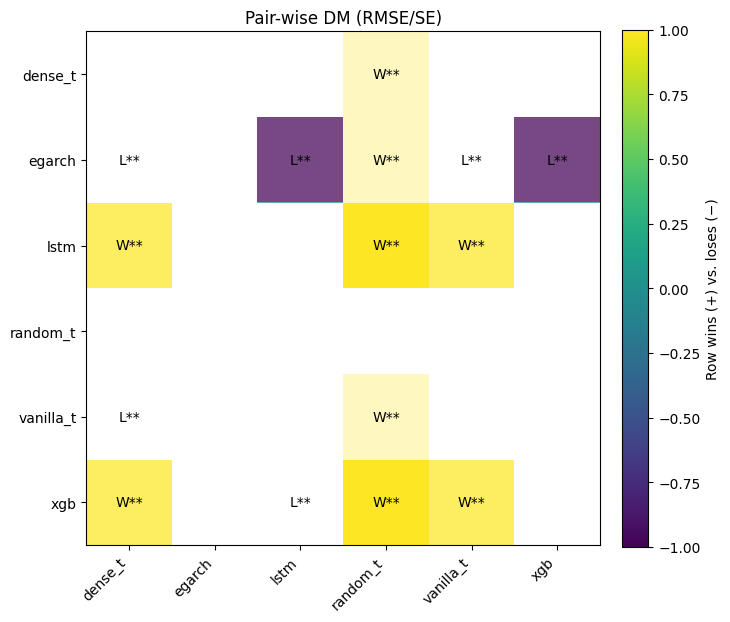

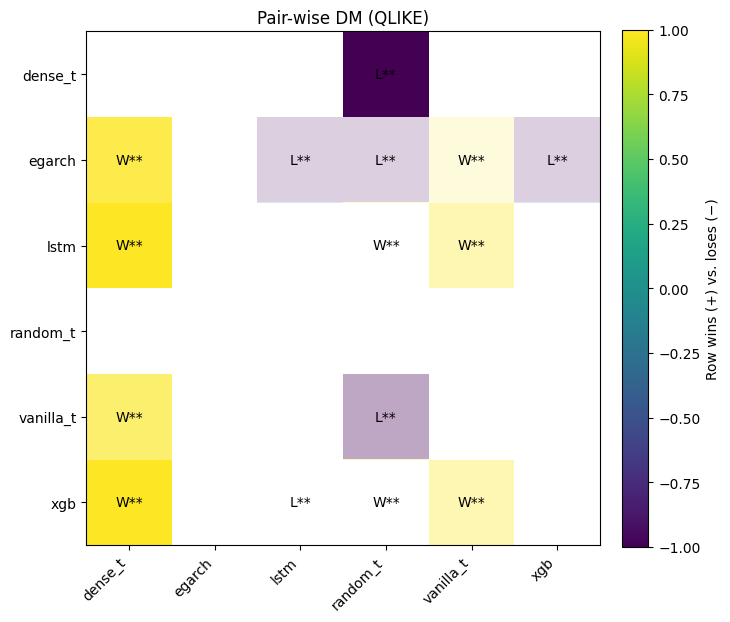

In [21]:
models = get_models(dm_df)

# Leaderboards
lb_rmse  = build_leaderboard(dm_df, loss='SE',    alpha=0.05)
lb_qlike = build_leaderboard(dm_df, loss='QLIKE', alpha=0.05)

print("=== Leaderboard (RMSE / SE) ===")
display(lb_rmse)

print("\n=== Leaderboard (QLIKE) ===")
display(lb_qlike)

# Separate heatmaps
plot_dm_heatmap(dm_df, loss='SE',    alpha=0.05, title="Pair-wise DM (RMSE/SE)")
plot_dm_heatmap(dm_df, loss='QLIKE', alpha=0.05, title="Pair-wise DM (QLIKE)")

